In [2]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os, sys, shutil, copy, time, random
from dataset import *
from models import *
from utils import *
from data_loaders import get_uci_datasets

In [13]:
class Args:
    def __init__(self):
        self.log_root='int_log'
        self.dataset = 'protein'

        self.train_bias_y = False
        self.train_bias_f = False
        self.train_cons = False
        self.train_calib = False
        self.re_calib = True
        self.re_bias_f = True
        self.re_bias_y = False

        # Modeling parameters
        self.model = 'big'
        self.learning_rate = 1e-3
        self.batch_size = 1024
        self.num_bins = 0
        self.knn = 200

        # Run related parameters
        self.gpu = 0
        self.num_epoch = 500
        self.run_label = 0
        self.num_run = 10

args = Args()

device = torch.device('cuda:%d' % args.gpu)
args.device = device

In [4]:


start_time = time.time()

if args.num_bins == 0:
    eval_bias = eval_bias_knn
    assert args.knn > 10 and args.knn % 2 == 0
    

while True:
    args.name = '%s/model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
        (args.dataset, args.model, 
         args.train_bias_y, args.train_bias_f, args.train_cons, args.train_calib, args.re_calib, args.re_bias_f, args.re_bias_y,
         args.batch_size, args.num_bins, args.knn, args.run_label)
    args.log_dir = os.path.join(args.log_root, args.name)
    if not os.path.isdir(args.log_dir):
        os.makedirs(args.log_dir)
        break
    args.run_label += 1
print("Run number = %d" % args.run_label)
writer = SummaryWriter(args.log_dir)
log_writer = open(os.path.join(args.log_dir, 'results.txt'), 'w')

global_iteration = 0
random.seed(args.run_label)  # Set a different random seed for different run labels
torch.manual_seed(args.run_label)

def log_scalar(name, value, epoch):
    writer.add_scalar(name, value, epoch)
    log_writer.write('%f ' % value)


Run number = 4


In [5]:
if args.re_calib or args.re_bias_f or args.re_bias_y:
    train_dataset, val_dataset, test_dataset, x_dim, y_dim, _= get_uci_datasets(args.dataset, split_seed=args.run_label, val_fraction=0.2, test_fraction=0.2) 
else:
    train_dataset, _, test_dataset, x_dim, y_dim, _ = get_uci_datasets(args.dataset, split_seed=args.run_label, val_fraction=0.0, test_fraction=0.2)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
train_bb_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)


Loading dataset protein....
Done loading dataset protein


In [6]:
# Define model and optimizer
model = model_list[args.model](x_dim[0]).to(device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.num_epoch // 20, gamma=0.9) 
# train_bb_iter = itertools.cycle(train_bb_loader)

bb = iter(train_bb_loader).next()
bb_counter = 0   # Only refresh bb every 100 steps to save computation


In [7]:


for epoch in range(20):
    model.train()
    train_l2_all = []
    for i, data in enumerate(train_loader):
        # Minimize L2
        optimizer.zero_grad()
        loss_l2 = eval_l2(model, data, args)
        train_l2_all.append(loss_l2.detach())
        loss_l2.mean().backward()
        optimizer.step()

        # Minimize any of the special objectives
        optimizer.zero_grad()

        if args.train_bias_y:
            loss_bias, _ = eval_bias(model, bb, args, axis='label')
            writer.add_scalar('bias_loss_y', loss_bias, global_iteration)
            loss_bias.backward()

        if args.train_bias_f:
            loss_bias, _ = eval_bias(model, bb, args, axis='prediction')
            writer.add_scalar('bias_loss_f', loss_bias, global_iteration)
            loss_bias.backward()                

        if args.train_cons:
            loss_cons, _ = eval_cons(model, bb, args, alpha=alpha)
            writer.add_scalar('cons_loss', loss_cons, global_iteration)
            loss_cons.backward()

        if args.train_calib:
            loss_calib, _ = eval_calibration(model, bb, args)
            writer.add_scalar('calib_loss', loss_calib, global_iteration)
            loss_calib.backward()
        optimizer.step()

        global_iteration += 1

        bb_counter += 1
        if bb_counter > 100:
            bb = iter(train_bb_loader).next()
            bb_counter = 0

    # Performance evaluation
    model.eval()
    with torch.no_grad():
        # Log the train and test l2
        train_l2_all = torch.cat(train_l2_all).mean()
        log_scalar('train_l2', train_l2_all.item(), global_iteration)

        test_l2_all = eval_l2(model, test_dataset[:], args).mean()
        log_scalar('test_l2', test_l2_all.item(), global_iteration)

#             train_bias_err, train_cons_err = make_plot(model, train_dataset[:], args, ('train-%d' % epoch) + '-%s.png', 
#                                                        do_plot=(epoch % 100 == 0), alpha=alpha)
#             test_bias_err, test_cons_err = make_plot(model, test_dataset[:], args, ('test-%d' % epoch) + '-%s.png',
#                                                     do_plot=(epoch % 100 == 0), alpha=alpha)
        # train_calib_err, _ = eval_calibration(model, test_dataset[:], args)
        test_bias_y, _ = eval_bias(model, test_dataset[:], args, axis='label')
        test_bias_f, _ = eval_bias(model, test_dataset[:], args, axis='prediction')
        test_calib_err, _ = eval_calibration(model, test_dataset[:], args)

#             log_scalar('train_bias_loss', train_bias_err, global_iteration)
#             log_scalar('train_cons_loss', train_cons_err, global_iteration)
        log_scalar('test_bias_y', test_bias_y, global_iteration)
        log_scalar('test_bias_f', test_bias_f, global_iteration)
        log_scalar('test_calib_loss', test_calib_err, global_iteration)

        thresholds = torch.linspace(0.1, 0.9, 8).to(device)
        fn, fp = eval_decisions(model, test_dataset[:], args, thresholds)
        for ti in range(8):
            log_scalar('fn_%d' % ti, fn[ti], global_iteration)
            log_scalar('fp_%d' % ti, fp[ti], global_iteration)
        log_scalar('fp+fn_all', fn.mean() + fp.mean(), global_iteration)

    log_writer.write('\n')
    log_writer.flush()

    print('global_iteration %d, time %.2f, %s' % (global_iteration, time.time() - start_time, args.name))
    scheduler.step()

global_iteration 915, time 36.65, protein/model=big-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=4
global_iteration 1830, time 43.85, protein/model=big-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=4
global_iteration 2745, time 52.19, protein/model=big-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=4
global_iteration 3660, time 61.03, protein/model=big-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=4
global_iteration 4575, time 69.89, protein/model=big-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=4
global_iteration 5490, time 78.42, protein/model=big-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=4
global_iteration 6405, time 86.91, protein/model=big-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=4
global_iteration 7320, time 95.66, protein/model=big-False-False-False-False-True-True-False-bs=1024-bin=0-100-run=4
global_iteration 8235, time 102.61, protein/model=big-False-False

In [8]:


class RecalibratorBias:
    def __init__(self, model, data, args, axis='label', verbose=False):
        self.axis = axis
#         self.flow = deeper_flow(layer_num=5, feature_size=20).to(args.device) 
        self.flow = NafFlow().to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        
        k = args.knn
        assert k % 2 == 0
        
        inputs, labels = data
        inputs = inputs.to(args.device)
        labels = labels.to(args.device).flatten()
        
        for iteration in range(5000):
            flow_optim.zero_grad()
            outputs = model(inputs).flatten()

            if axis == 'label':
                ranking = torch.argsort(labels)
            else:
                assert axis == 'prediction'
                ranking = torch.argsort(outputs)

            sorted_labels = labels[ranking]
            sorted_outputs = outputs[ranking]

            smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                        weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                        padding=0).flatten()
            smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                       weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                       padding=0).flatten()
            
            adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
            loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
            loss_bias.backward()
            flow_optim.step()
            
            if verbose and iteration % 100 == 0:
                print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)
    


In [9]:
class Recalibrator:
    # This class is untested 
    def __init__(self, model, data, args, re_calib=False, re_bias_f=False, re_bias_y=False, verbose=False):
        self.args = args
        self.re_calib = re_calib
        self.re_bias_f = re_bias_f 
        self.re_bias_y = re_bias_y
        self.model = model  # regression model        
        self.flow = NafFlow(feature_size=40).to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        # flow_scheduler = torch.optim.lr_scheduler.StepLR(flow_optim, step_size=100, gamma=0.9)

        k = args.knn
        assert k % 2 == 0
        assert re_calib or re_bias_f or re_bias_y 
        
        inputs, labels = data
        inputs = inputs.to(self.args.device)
        labels = labels.to(self.args.device).flatten()
        
        for iteration in range(5000):
            flow_optim.zero_grad()
            loss_all = 0.0
            outputs = model(inputs).flatten()
            
            for objective in range(2):
                if objective == 0 and self.re_bias_f:
                    ranking = torch.argsort(outputs)
                elif objective == 1 and self.re_bias_y:
                    ranking = torch.argsort(labels)
                else:
                    continue
                sorted_labels = labels[ranking]
                sorted_outputs = outputs[ranking]

                smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                            weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                            padding=k // 2).flatten()
                smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                           weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                           padding=k // 2).flatten()
                adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                loss_all += loss_bias 

            if re_calib:
                labels = torch.sort(labels.flatten())[0]
                outputs = torch.sort(outputs.flatten())[0]
                adjusted_outputs, _ = self.flow(outputs.view(-1, 1))
                loss_bias = (labels - adjusted_outputs.view(-1)).pow(2).mean()
                loss_all += loss_bias

            loss_all.backward()
            flow_optim.step()
            # flow_scheduler.step()
            if verbose and iteration % 100 == 0:
                print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)

#     def __init__(self, model, data, args, re_calib=False, re_bias_f=False, re_bias_y=False, verbose=False):

In [14]:
# args.knn = 200


def plot_knn(model, data, args, axis='label'):
    k = args.knn
    assert k % 2 == 0

    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device).flatten()
    outputs = model(inputs).flatten()

    if axis == 'label':
        ranking = torch.argsort(labels)
    else:
        assert axis == 'prediction'
        ranking = torch.argsort(outputs)

    sorted_labels = labels[ranking]
    sorted_outputs = outputs[ranking]

    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                padding=k // 2).flatten()
    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                               padding=k // 2).flatten()
    return smoothed_labels[k//2+1:-k//2-1], smoothed_outputs[k//2+1:-k//2-1]

def plot_calibration(model, data, args):
    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(inputs)
    
    labels, _ = torch.sort(labels.flatten())
    outputs, _ = torch.sort(outputs.flatten())
    return labels, outputs

def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

# recalibrator = RecalibratorBias_flow(model, )
model.eval()
import seaborn as sns
palette = np.array(sns.color_palette('husl', 8))[[0, 5, 7]]

plot_lim = [-1.2, 2.1]
fontsize = 14
x = torch.linspace(val_dataset[:][1].min(), val_dataset[:][1].max(), 200).to(device)

# recalib_size = 100

recalibrator_bias_f = RecalibratorBias(model, val_dataset[:], args, axis='prediction', verbose=False)
recalibrator_bias_y = RecalibratorBias(model, val_dataset[:], args, axis='label', verbose=False)
recalibrator_calib = Recalibrator(model, val_dataset[:], args, re_calib=True, verbose=False)


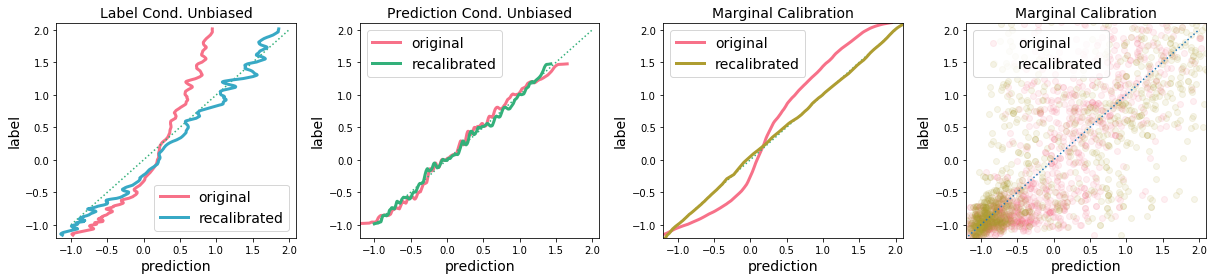

In [15]:
palette = sns.color_palette('husl', 5)
with torch.no_grad():
    plt.figure(figsize=(17, 4))
    model.recalibrator = None



    plt.subplot(1, 4, 1)
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original', linewidth=3) 
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.ylabel('label', fontsize=fontsize)
    plt.xlabel('prediction', fontsize=fontsize) 
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)

    plt.subplot(1, 4, 2)
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original', linewidth=3) 
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.xlabel('prediction', fontsize=fontsize)
    plt.ylabel('label', fontsize=fontsize)
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    
    plt.subplot(1, 4, 3)
    labels, outputs = plot_calibration(model, test_dataset[:], args)
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original', linewidth=3)
    plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
    plt.xlabel('prediction', fontsize=fontsize) 
    plt.ylabel('label', fontsize=fontsize)
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)



    plt.subplot(1, 4, 1)
    model.recalibrator = recalibrator_bias_y
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[3], label='recalibrated', linewidth=3) 
    y = recalibrator_bias_y.adjust(x.view(-1, 1))
    # plt.plot(y.detach().cpu(), x.cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    plt.title('Label Cond. Unbiased', fontsize=fontsize)

    plt.subplot(1, 4, 2)
    model.recalibrator = recalibrator_bias_f
    labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[2], label='recalibrated', linewidth=3) 
    y = recalibrator_bias_f.adjust(x.view(-1, 1))
    # plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    plt.title('Prediction Cond. Unbiased', fontsize=fontsize)

    
    plt.subplot(1, 4, 3)
    model.recalibrator = recalibrator_calib
    labels, outputs = plot_calibration(model, test_dataset[:], args)
    plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='recalibrated', linewidth=3)
    y = recalibrator_calib.adjust(x.view(-1, 1))
    # plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
    plt.legend(fontsize=fontsize)
    plt.title('Marginal Calibration', fontsize=fontsize)

    plt.subplot(1, 4, 4)
    model.recalibrator = None
    inputs, labels = val_dataset[:]
    inputs = inputs.to(args.device)
    labels = labels.to(args.device).flatten()
    outputs = model(inputs)
    adjusted_outputs = recalibrator_calib.adjust(outputs)
    idx = np.random.choice(np.arange(len(labels)), 1000)
    plt.scatter(outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[0], label='original')
    plt.scatter(adjusted_outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[1], label='recalibrated')
    plt.plot([-1.5, 2.0], [-1.5, 2.0], linestyle=':')
    plt.xlim(plot_lim)
    plt.ylim(plot_lim)
    plt.xlabel('prediction', fontsize=fontsize) 
    plt.ylabel('label', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.title('Marginal Calibration', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('plots/recalib_curve_%d.png' % (args.knn))

    plt.show()

